# Histopathologic Cancer Detection  
## CSPB 3202 - Homework 5  
Name: Nicole Lincoln
github: https://github.com/nikkilinx/3202_HW_5  
kaggle userID: nicolelincoln, display name: Nicole Lincoln

We have been asked to participate in this Kaggle challenge for Homework 5.
Our requirements include:

1. Brief description of the problem, data (e.g. size and dimension, structure etc)
2. Exploratory data analysis showing a few visualization, histogram, etc, and a plan of analysis. Any data cleaning procedure.
3. Model architecture and reasoning why you believe certain architecture would be suitable for this problem
4. Results (tables, figures etc) and analysis (reasoning of why or why not something worked well, also troubleshooting and hyperparameter optimization procedure summary)
5. Conclusion

In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## References and Resources

### General Resources: 
https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9  
https://arxiv.org/abs/1409.1556
https://cs231n.github.io/convolutional-networks/  
https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480
https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/  
https://medium.com/machine-learning-world/convolutional-neural-networks-for-all-part-ii-b4cb41d424fd  
https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/  
https://keras.io/api/models/model_training_apis/  
https://towardsdatascience.com/dont-overfit-how-to-prevent-overfitting-in-your-deep-learning-models-63274e552323  
https://ruder.io/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms
  
### Notebooks   

https://colab.research.google.com/drive/1IctSzyugG9YLJKhg7WAlRtGi0nEIxy9y#scrollTo=FKiwTuT-NE6f (Fashion MNIST notebook from lecture)  
https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing  
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb  
https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93  
https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai  
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6#3.-CNN  

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns

import cv2  

# import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import models
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import layers
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam


from glob import glob 
from skimage.io import imread #read images from files

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import itertools
import shutil
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import random
import time

# Image processing
import imageio
import skimage
import skimage.io
import skimage.transform
from skimage.io import imread #read images from files

import gc

In [42]:
IMAGE_ROWS = 96
IMAGE_COLS = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 30000 # the number of images we use from each of the two classes

# 1. Statement of the Problem 

For the data, we have 277,483 images, and a training set label file. 

This is a binary classification problem, where the goal is to determine whether an image contains metastatic cancer. The images are size 96x96, but the tumor tissue must be within the center 32X32 region in order to be considered a positive result. There are no duplicate images. 

A training set of images is provided, along with a smaller set of test images. There is also a csv file that contains the labels for the training set. 

The output for this is simply a label identifying the probability that and image contains tumor tissue (closer to 1) or does not (closer to 0). 

This is my first time working with images, so I reviewed some of the available notebooks to better understand how to work with these images.  

In [43]:
path = "../input/histopathologic-cancer-detection/"
train_path = path + 'train/'
test_path = path + 'test/'

print(len(os.listdir(train_path)))
print(len(os.listdir(test_path)))

220025
57458


First, I created a dataframe that linked the images with its label. Since the images don't inherently identify whether they contain tumor tissue our not, they must be linked with the correct label provided by the csv file. 

In [44]:
# source: https://www.kaggle.com/hrmello/base-cnn-classification-from-scratch
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0])
labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
df = df.merge(labels, on = "id")
df.head()

,path,id,label
0,../input/histopathologic-cancer-detection/train/8cf60354fa8131e0b34dc84885f4856328b0f181.tif,8cf60354fa8131e0b34dc84885f4856328b0f181,0
1,../input/histopathologic-cancer-detection/train/329a8dff832e447be040757f4b633a30b2818397.tif,329a8dff832e447be040757f4b633a30b2818397,1
2,../input/histopathologic-cancer-detection/train/79cf6ef9063838815b627fb335fab1b48756585b.tif,79cf6ef9063838815b627fb335fab1b48756585b,1
3,../input/histopathologic-cancer-detection/train/c99fab86528ae0012aa3ca46a79ce8e6c11d0da4.tif,c99fab86528ae0012aa3ca46a79ce8e6c11d0da4,1
4,../input/histopathologic-cancer-detection/train/ef65e3f5906fc79055bf6aee837a6b7a23c61707.tif,ef65e3f5906fc79055bf6aee837a6b7a23c61707,0


#  2. Exploratory Data Analysis  
 
For my EDA, I printed out images of each type to see if there was any clear visual difference between positive and negative tissue samples. I couldn't discern any difference, but I also have no idea what I am looking for. I then printed out a histogram to see how balanced our data was. The data was imbalanced, in favor of negative tissue. When creating the array of images, this skew is balanced out by selecting an even number of both types of images. 

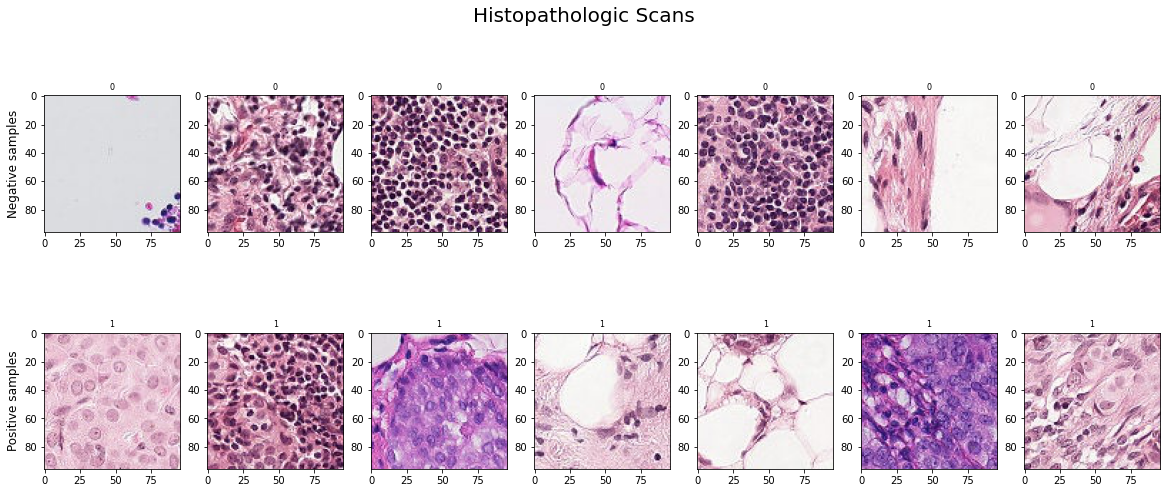

In [45]:
# https://www.kaggle.com/dmitrypukhov/honey-bee-health-detection-with-cnn (how to display images)
# https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai (boxes showing 32x32 point of interest)

ncols = 7
negative = df[df['label'] == 0].sample(ncols)
positive = df[df['label'] == 1].sample(ncols)


f, ax = plt.subplots(nrows=2,ncols=ncols, figsize=(20,8))
f.suptitle('Histopathologic Scans',fontsize=20)

for i in range(0,ncols): 
    file = negative.iloc[i]['path']
    ax[0,i].imshow(imageio.imread(file))
    ax[0,i].set_title(negative.iloc[i]['label'], fontsize=8)
ax[0,0].set_ylabel('Negative samples', size='large')

for i in range(0,ncols): 
    file = positive.iloc[i]['path']
    ax[1,i].imshow(imageio.imread(file))
    ax[1,i].set_title(positive.iloc[i]['label'], fontsize=8)
ax[1,0].set_ylabel('Positive samples', size='large');

0    130908
1     89117
Name: label, dtype: int64

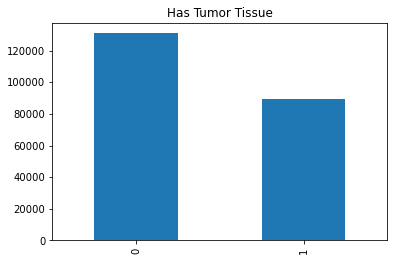

In [46]:
# show distribution of postive and negative images
df['label'].value_counts().plot.bar()
plt.title('Has Tumor Tissue')
df['label'].value_counts()

The data has an uneven split between positive and negative tumor tissue samples. When we grab our training data, we will balance these values. 

In [47]:
#Balance Data, select training data 

df0 = df[df.label == 0].sample(SAMPLE_SIZE, random_state = 33)
df1 = df[df.label == 1].sample(SAMPLE_SIZE, random_state = 33)

df_data = pd.concat([df0, df1], ignore_index=True).reset_index()
df_data = df_data[["path", "id", "label"]]
df_data = df_data.sample(frac = 1)
print(df_data['label'].value_counts())

1    30000
0    30000
Name: label, dtype: int64


Below, I have split the data into a training set and a validation set. The training set will train my model, and the validation set will allow me to see how well my model is performing. If it is overfitting, the validation set should allow me to identify that and make some adjustments. 

In [48]:
#split into training and validation set 
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

train_labels = df_train['label'].to_numpy()  #convert label column to array for training purposes to compare with results
train_imgs = ['../input/histopathologic-cancer-detection/train/{}.tif'.format(i) for i in df_train['id']] #array of images 

val_labels = df_val['label'].to_numpy()
val_imgs = ['../input/histopathologic-cancer-detection/train/{}.tif'.format(i) for i in df_val['id']]


In order to evaluate the images, they need to be processed. This turns the images into a list of RBG colors, which is then converted into a numpy array.  

In [49]:
#Code to change images into format of array of image pixel values 
# Source: https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9

def read_and_process(images):
    X = []
    for image in images: 
        X.append(cv2.resize(cv2.imread(image,cv2.IMREAD_COLOR),(IMAGE_ROWS,IMAGE_COLS),interpolation=cv2.INTER_CUBIC))
    return X

X_train = read_and_process(train_imgs)
X_val = read_and_process(val_imgs)
print(X_train[0])

[[[200 143 188]
  [218 159 209]
  [185 123 177]
  ...
  [178 106 202]
  [194 132 216]
  [236 179 254]]

 [[189 127 175]
  [189 126 176]
  [158  91 146]
  ...
  [195 123 213]
  [191 125 206]
  [198 137 211]]

 [[199 131 184]
  [192 124 179]
  [213 141 201]
  ...
  [211 137 219]
  [212 144 221]
  [197 133 205]]

 ...

 [[174 106 171]
  [194 122 188]
  [243 169 233]
  ...
  [224 158 229]
  [185 115 192]
  [191 119 202]]

 [[175 106 173]
  [207 135 201]
  [193 119 185]
  ...
  [215 149 220]
  [201 132 207]
  [207 137 214]]

 [[184 113 180]
  [192 119 187]
  [220 146 212]
  ...
  [161  96 165]
  [176 110 182]
  [213 144 219]]]


In [50]:
X_train = np.array(X_train)
X_val = np.array(X_val)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
print("Shape of training images is:",X_train.shape)
print("Shape of training images is:",X_val.shape)
print("Shape of training images is:",train_labels.shape)
print("Shape of training images is:",val_labels.shape)

Shape of training images is: (54000, 96, 96, 3)
Shape of training images is: (6000, 96, 96, 3)
Shape of training images is: (54000,)
Shape of training images is: (6000,)


# 3. Model Architecture 


After revewing several articles and existing Notebooks, I landed on a small VGG model with 5 layers.  Each block has a convolution network with a 3 x 3 filter, and then a maxpooling layer that uses a 2x2 filter. 

I also used the ReLU activation function for all layers except the output, since it is the most common activiation function and it was recommended for inner layers for better convergence. 

I used the sigmoid function in the output layer, since we were doing binary classification with these images. Using the sigmoid function outputs the probability between 0 and 1 of how sure an image is to be positive for tumor tissue (higher probability). 


I originally tried to use one of the more complex models in some of the notebooks, however, the amount of overfitting I was seeing was significant. I tweaked several hyperparameters (more details below) and tried to alter things like the number of input images, however, none of that made a difference to the overfitting. After some research, I determined that my model was too complex, and needed to be simpler. 

I also tried using padding, but it decreased the performance of my model, so I did not end up using that in my final model. 

For my model optimizer, I used the Adam optimizer. Through most of my research on using Keras and CNNs, this was the most widely recommended optimizer. The Adam optimizer seems to have the benefits of classic SGD, but also additional benefit of maintaining separate learning rates for each parameter. It is also alleged to b faster than classic SGD, but I was unable to compare the two on this homework due to gpu time constraints. If I had more time with my gpu, I would try the SGD optimizer to compare which performed better. 

In [51]:

# #https://stackoverflow.com/questions/42883547/intuitive-understanding-of-1d-2d-and-3d-convolutions-in-convolutional-neural-n
# # https://towardsdatascience.com/image-detection-from-scratch-in-keras-f314872006c9

filter_size = (3,3)
pool_size = (2,2)

first_filters = 32
second_filters = 64
third_filters = 128

dropout_dense = 0.5

model = models.Sequential()
# Layer 1: Input Layer
model.add(layers.Conv2D(first_filters, filter_size, activation='relu',input_shape=(IMAGE_ROWS, IMAGE_COLS, IMAGE_CHANNELS)))
model.add(layers.MaxPooling2D(pool_size))

# Layer 2
model.add(layers.Conv2D(second_filters, filter_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size))
# Layer 3
model.add(layers.Conv2D(third_filters, filter_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size))
# Layer 4
model.add(layers.Conv2D(third_filters, filter_size, activation='relu'))
model.add(layers.MaxPooling2D(pool_size))

# Layer 5: Output Layer
model.add(layers.Flatten())
model.add(layers.Dropout(dropout_dense))  #Dropout for regularization
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)        

In [52]:
#compile the model 
optimizer = Adam(0.0001)

model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

In [53]:
epochs=24
batch_size = 100

history = model.fit(X_train, train_labels, batch_size = batch_size, epochs = epochs,
                   validation_data = (X_val,val_labels), verbose=1);

Epoch 1/24
540/540 [==============================] - 8s 16ms/step - loss: 0.6422 - accuracy: 0.7451 - val_loss: 0.4746 - val_accuracy: 0.7773
Epoch 2/24
540/540 [==============================] - 8s 15ms/step - loss: 0.4646 - accuracy: 0.7884 - val_loss: 0.4651 - val_accuracy: 0.7772
Epoch 3/24
540/540 [==============================] - 8s 15ms/step - loss: 0.4452 - accuracy: 0.7981 - val_loss: 0.4150 - val_accuracy: 0.8092
Epoch 4/24
540/540 [==============================] - 8s 15ms/step - loss: 0.4187 - accuracy: 0.8126 - val_loss: 0.4033 - val_accuracy: 0.8255
Epoch 5/24
540/540 [==============================] - 8s 15ms/step - loss: 0.4035 - accuracy: 0.8209 - val_loss: 0.4434 - val_accuracy: 0.7948
Epoch 6/24
540/540 [==============================] - 9s 16ms/step - loss: 0.3840 - accuracy: 0.8296 - val_loss: 0.4118 - val_accuracy: 0.8440
Epoch 7/24
540/540 [==============================] - 8s 16ms/step - loss: 0.3748 - accuracy: 0.8340 - val_loss: 0.3763 - val_accuracy: 0.8410

# 4. Results and Analysis

Below, I have plotted a few graphs to show the results of my model fitting and testing. 

The first plots show the accuracy and loss against the epochs. The training and validation follow a similar path for awhile. After about 15 epochs, the accuracy and loss for the validation data set seems to plateau. With more time, I would continue to run this trying different epochs, and with early-stopping, which would limit the number of epochs if the loss increases.  

There were several things I tried that just did not end up working. The first was a similar, but more complex model. There were several notebooks in Kaggle that used a model that had several blocks of layers, and used batch normalization, along with dropout for each of the blocks. However, when I tried using these models, I had major overfitting problems. With the more complex model, I tried tuning some of the hyperparameters, such as batch size, learning rate, dropout rate, epochs. However, none of this seemed to make any difference. Additionally, I tried using different training data sizes, and that didn't help either. I also tried normalizing the data, and although it helped, it was a minimal amount, and not enough to prevent a significant amount of overfitting. 

After doing some additional research on what could be causing such bad overfitting, I came to the conclusion that my network was likely too complex. I tried using a simpler model, one that just used 5 layers, eliminated the batch normalization and the intermediate dropout step. After doing this, I immediately noticed an improvement in the model performance. 

I also adjusted the learning rate parameter from .01 to .001 and ultimately landed on .0001. This made a significant improvement in my model's performance with the overfitting. With the highler .01 learning rate, I think I was overshooting the global minimum. Adjusting the learning rate to .0001 worked the best out of the 3 values I tried. 

Even though, in the grand scheme of things, there aren't that many hyperparameters to tune, each of those parameters can hold many different values, and it was very difficult to try to decide where to start and how much of a change to make with each one. This difficulty is compounded by the fact that it can take a lot of time to fit the model after each change, and the fact that there is limited memory to hold all the images. 

I found a stackoverflow post that I thought gave some really great ideas on how to unit test and improve the network: https://stats.stackexchange.com/a/352037.  One of the things I had trouble keeping track of was what hyperparameters or inputs I had changed and used together, and what combinations were left to try. The recommendation of keeping a logbook of experiments seems imperative when you are trying to build and train a CNN.  


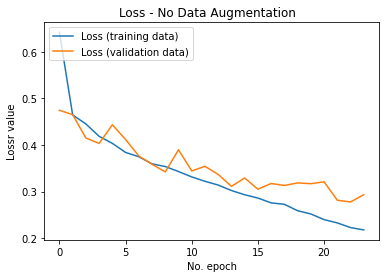

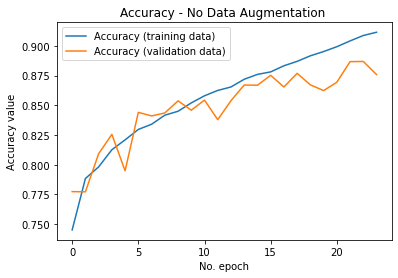

In [54]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot history: Loss
plt.plot(loss, label='Loss (training data)')
plt.plot(val_loss, label='Loss (validation data)')
plt.title('Loss - No Data Augmentation  ')
plt.ylabel('Lossr value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Plot history: Accuracy
plt.plot(acc, label='Accuracy (training data)')
plt.plot(val_acc, label='Accuracy (validation data)')
plt.title('Accuracy - No Data Augmentation ')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [56]:
#Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

# predict probabilities for test set
yhat_probs = model.predict(X_val, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_val, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(val_labels, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(val_labels, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(val_labels, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(val_labels, yhat_classes)
print('F1 score: %f' % f1)
 

# ROC AUC
roc_auc = roc_auc_score(val_labels, yhat_probs)
print('ROC AUC: %f' % roc_auc)
# confusion matrix
matrix = confusion_matrix(val_labels, yhat_classes)
print(matrix)

Accuracy: 0.875833
Precision: 0.848963
Recall: 0.914333
F1 score: 0.880437
ROC AUC: 0.951040
[[2512  488]
 [ 257 2743]]


In [57]:
from sklearn.metrics import roc_curve, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_labels, yhat_probs)
auc_keras = auc(fpr_keras, tpr_keras)

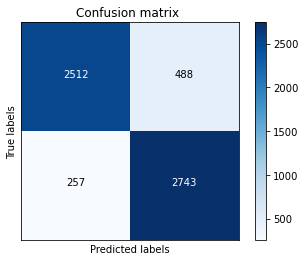

In [58]:
# Source: https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing/execution
plt.imshow(matrix, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()

thresh = matrix.max() / 2.
for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j]),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")
plt.show()

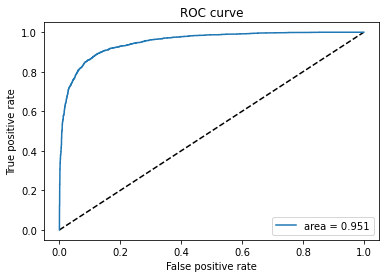

In [59]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [60]:
del train_imgs
del val_imgs
gc.collect(); 

Here, I am creating the required output file.

In [61]:
# Source: https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

#create a dataframe to hold results
test_files = glob(os.path.join(test_path,'*.tif')) #find the test file names
submission = pd.DataFrame() #create a dataframe to hold results
file_batch = 5000 #we will predict 5000 images at a time
max_idx = len(test_files) #last index to use
for idx in range(0, max_idx, file_batch): #iterate over test image batches
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) #add the filenames to the dataframe
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[4].split(".")[0]) #add the ids to the dataframe
    test_df['image'] = test_df['path'].map(cv2.imread) #read the batch
    K_test = np.stack(test_df["image"].values) #convert to numpy array
    predictions = model.predict(K_test,verbose = 1) #predict the labels for the test data
    test_df['label'] = predictions #store them in the dataframe
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() #display first lines

Indexes: 0 - 5000
157/157 [==============================] - 0s 3ms/step
Indexes: 5000 - 10000
157/157 [==============================] - 0s 2ms/step
Indexes: 10000 - 15000
157/157 [==============================] - 0s 2ms/step
Indexes: 15000 - 20000
157/157 [==============================] - 0s 2ms/step
Indexes: 20000 - 25000
157/157 [==============================] - 0s 2ms/step
Indexes: 25000 - 30000
157/157 [==============================] - 0s 2ms/step
Indexes: 30000 - 35000
157/157 [==============================] - 0s 2ms/step
Indexes: 35000 - 40000
157/157 [==============================] - 0s 2ms/step
Indexes: 40000 - 45000
157/157 [==============================] - 0s 2ms/step
Indexes: 45000 - 50000
157/157 [==============================] - 0s 3ms/step
Indexes: 50000 - 55000
157/157 [==============================] - 0s 2ms/step
Indexes: 55000 - 60000
77/77 [==============================] - 0s 3ms/step


,id,label
0,eb9e445089aed6402ef64ab0b416a31dfe73fae1,0.100640
1,2e7b0bdc8d15a47f26fb7db84d566f1e773fb708,0.976919
2,a1a9367e1a79f8e807019e2455d6be52d86c2678,0.066193
3,dbc6c9872643f51667bbdfe816c4c5e5b6238706,0.110360
4,a3395030af2286eff7bd94e5dc5a3ddbe5f9c591,0.787593


In [ ]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file

#  5. Conclusion

For my submission, I scored a .91 Public Score, and a .8691 private score. 

Given the complexity of this data, I was surprised that the more complex networks performed worse for me. Obviously they perform well with this data generally since the same model is used frequently throughout the available notebooks. My intuition is that part of the problem might lay in the inability to use more of the images for training purposes. I was unable to use more than 60K images for training because the Kaggle kernel kept running out of memory. There were notebooks that did explain how to use all of the images, however, I didn't focus as much on those since I wanted to spend more time with the actual model, instead of learning how to upload images. If I had been able to use more of the training data, a more complex model may have been more appropriate.  Also, perhaps since the images themselves may not be extremely complex (mostly just circles and ovals of different shapes and sizes, instead of different facial or environment features), the more complex network was not appropriate. 

Ultimately, this was a very interesting exercise in learning how CNNs can be used to classify images. I have a better understanding of how the models work. However, I definitely don't feel like I have enough of an understanding to decide in advance how many layers are ideal for a certain problem. In this instance, it wwas more of "try what's out there and see what works", as opposed to understanding what my images contain and why they need X # of layers. The understanding of the ideal number of layers, what features to use, where to use dropout layers, etc, seems to be a much more nuanced problem than what a beginning set of lectures can really provide. 



